In [39]:
# import pakage
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from tensorflow.keras.regularizers import l2
from keras.layers import Dense, Dropout, Embedding

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score,accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Attention
from tensorflow.keras.optimizers import Adam
import os
import pickle
import matplotlib.pyplot as plt
from src.logger import logging


In [40]:
# load database and clear data set
df = pd.read_csv('dataset_model/dataset_phishing.csv')
df = df.sample(frac=1).reset_index(drop=True)
df['is_phishing'] = df['status'].apply(lambda x: 1 if x=='legitimate' else 0)
selectedFeatures = ['url',
                    'length_url',
                    'length_hostname',
                    'ip',
                    'nb_dots',
                    'nb_qm',
                    'nb_eq',
                    'nb_slash',
                    'nb_www',
                    'ratio_digits_url',
                    'ratio_digits_host',
                    'tld_in_subdomain',
                    'prefix_suffix',
                    'shortest_word_host',
                    'longest_words_raw',
                    'longest_word_path',
                    'phish_hints',
                    'nb_hyperlinks',
                    'ratio_intHyperlinks',
                    'empty_title',
                    'domain_in_title',
                    'domain_age',
                    'google_index',
                    'page_rank',
                    'is_phishing']

df = df.loc[:, selectedFeatures]
train_df, test_df = train_test_split(df, test_size=0.20, random_state=42)

train_df.to_csv("dataset_model/train.csv", index=False, header=True)

test_df.to_csv("dataset_model/test.csv", index=False, header=True)


In [41]:
# data transformation and StandardScaler
unnecessary_column_name = 'url'

train_df = train_df.drop(columns=[unnecessary_column_name], axis=1)
test_df = test_df.drop(columns=[unnecessary_column_name], axis=1)

target_column_name = 'is_phishing'

input_feature_train_df = train_df.drop(columns=[target_column_name], axis=1)
target_feature_train_df = train_df[target_column_name]

input_feature_test_df = test_df.drop(columns=[target_column_name], axis=1)
target_feature_test_df = test_df[target_column_name]

scaler = StandardScaler()
input_feature_train_df = scaler.fit_transform(input_feature_train_df)
input_feature_test_df = scaler.transform(input_feature_test_df)

train_arr = np.c_[
    input_feature_train_df, np.array(target_feature_train_df)
]
test_arr = np.c_[
    input_feature_test_df, np.array(target_feature_test_df)
]

In [42]:
# Create function for save file
def save_object(file_path, obj):
    dir_path = os.path.dirname(file_path)

    os.makedirs(dir_path, exist_ok=True)
    with open(file_path, "wb") as file_obj:
        pickle.dump(obj, file_obj)

In [43]:
# set up data for model train 
X_train, y_train, X_test, y_test =(
    train_arr[:,:-1],
    train_arr[:,-1],
    test_arr[:,:-1],
    test_arr[:,-1]
)

In [44]:
# train model by ML
models = {
        'Logistic Regression': LogisticRegression(),
        'Random Forest': RandomForestClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'SVM': SVC(),
        'KNN': KNeighborsClassifier(),
        'XGBClassifier': XGBClassifier()
        }

params={
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs'],
        'max_iter': [100, 200, 500]
    },
    'Random Forest': {
        'n_estimators': [100, 150],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'p': [1, 2]  # 1 for Manhattan, 2 for Euclidean
    },
    'XGBClassifier' : {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5],
        'n_estimators': [100, 200]
    }
    
}

for i in range(len(models)):
    model_name = list(models.keys())[i]
    model = list(models.values())[i]
    para = params[list(models.keys())[i]]

    gs = GridSearchCV(model, para, cv=5, n_jobs=-1, scoring='accuracy')
    gs.fit(X_train,y_train)

    model.set_params(**gs.best_params_)
    model.fit(X_train,y_train)

    # model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)

    y_test_pred = model.predict(X_test)

    train_model_score = r2_score(y_train, y_train_pred)

    test_model_score = r2_score(y_test, y_test_pred)

    mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mse)
    test_accuracy_score = accuracy_score(y_test, y_test_pred)
    test_precision_score = precision_score(y_test, y_test_pred)
    test_recall_score = recall_score(y_test, y_test_pred)
    test_f1_score = f1_score(y_test, y_test_pred)

    logging.info(f"---------------------{model_name}-------------------")
    logging.info(f"Mean Squared Error (MSE): {mse :.2f}")
    logging.info(f"Root Mean Squared Error (RMSE): {rmse :.2f}")
    logging.info(f"R2 score Train: {train_model_score :.2f}")
    logging.info(f"R2 score Test: {test_model_score :.2f}")
    logging.info(f"Accuracy: {test_accuracy_score :.2f}")
    logging.info(f"Precision: {test_precision_score :.2f}")
    logging.info(f"Recall: {test_recall_score :.2f}")
    logging.info(f"F1 Score: {test_f1_score :.2f}")
    logging.info(f"-----------------------------------------------------------------")

    trained_model_file_path = os.path.join("dataset_model", f"{list(models.keys())[i][0]}_model.pkl")
    save_object(
        file_path=trained_model_file_path,
        obj = model
    )

         

In [45]:
# Ensemble Learning in Machine Learning
# Define individual models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
svc = SVC(probability=True, random_state=42)

# Ensemble using Voting
ensemble = VotingClassifier(estimators=[
    ('rf', rf), ('gb', gb), ('svc', svc)
], voting='soft')

# Train the ensemble model
ensemble.fit(X_train, y_train)

# Evaluate

y_test_pred = ensemble.predict(X_test)

train_model_score = r2_score(y_train, y_train_pred)

test_model_score = r2_score(y_test, y_test_pred)

mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
test_accuracy_score = accuracy_score(y_test, y_test_pred)
test_precision_score = precision_score(y_test, y_test_pred)
test_recall_score = recall_score(y_test, y_test_pred)
test_f1_score = f1_score(y_test, y_test_pred)

trained_model_file_path = os.path.join("dataset_model", f"Ensemble_Learning_model.pkl")
save_object(
    file_path=trained_model_file_path,
    obj = model
)

logging.info(f"---------------------Ensemble using Voting-------------------")
logging.info(f"Mean Squared Error (MSE): {mse :.2f}")
logging.info(f"Root Mean Squared Error (RMSE): {rmse :.2f}")
logging.info(f"R2 score Train: {train_model_score :.2f}")
logging.info(f"R2 score Test: {test_model_score :.2f}")
logging.info(f"Accuracy: {test_accuracy_score :.2f}")
logging.info(f"Precision: {test_precision_score :.2f}")
logging.info(f"Recall: {test_recall_score :.2f}")
logging.info(f"F1 Score: {test_f1_score :.2f}")
logging.info(f"-----------------------------------------------------------------")

In [46]:
# Deep learning

# Define the model
model = Sequential()
model.add(Input(shape=(23,)))  # Input layer

# Hidden layers with Dropout and L2 Regularization
model.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))  # Dropout with a rate of 50%
model.add(Dense(units=64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(units=32, activation='relu', kernel_regularizer=l2(0.01)))

# Output layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
opt = Adam(learning_rate=0.00009)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001,  # Minimum improvement to qualify as an epoch improvement
    patience=20,  # Stop after 10 epochs without improvement
    restore_best_weights=True,
)

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=150,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
y_pred = model.predict(X_test) > 0.5  # Predict probabilities and convert to binary

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


logging.info(f"---------------------- USE ANN ------------------------------------------")
logging.info(f"Mean Squared Error (MSE): {mse:.2f}")
logging.info(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
logging.info(f"Accuracy: {accuracy:.2f}")
logging.info(f"Precision: {precision:.2f}")
logging.info(f"Recall: {recall:.2f}")
logging.info(f"F1 Score: {f1:.2f}")
logging.info(f"-----------------------------------------------------------------")

trained_model_file_path = os.path.join("dataset_model", "ANN_model.pkl")

save_object(
    file_path=trained_model_file_path,
    obj = model
)


Epoch 1/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5429 - loss: 2.2479 - val_accuracy: 0.8639 - val_loss: 1.9165
Epoch 2/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8010 - loss: 1.8722 - val_accuracy: 0.8967 - val_loss: 1.5728
Epoch 3/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8803 - loss: 1.5494 - val_accuracy: 0.9131 - val_loss: 1.3123
Epoch 4/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9035 - loss: 1.3007 - val_accuracy: 0.9169 - val_loss: 1.1229
Epoch 5/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9129 - loss: 1.1239 - val_accuracy: 0.9229 - val_loss: 0.9749
Epoch 6/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9132 - loss: 0.9758 - val_accuracy: 0.9267 - val_loss: 0.8543
Epoch 7/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9187 - loss: 0.8643 - val_accuracy: 0.9278 - val_loss: 0.7536
Epoch 8/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9257 - loss: 0.7583 - val_accu

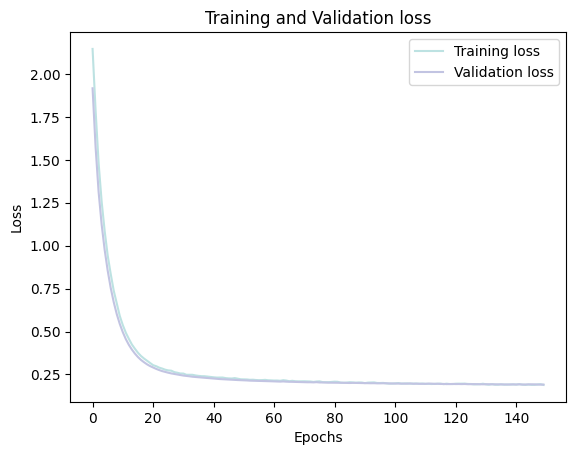

In [47]:
# Plotting training and validation loss over epochs
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

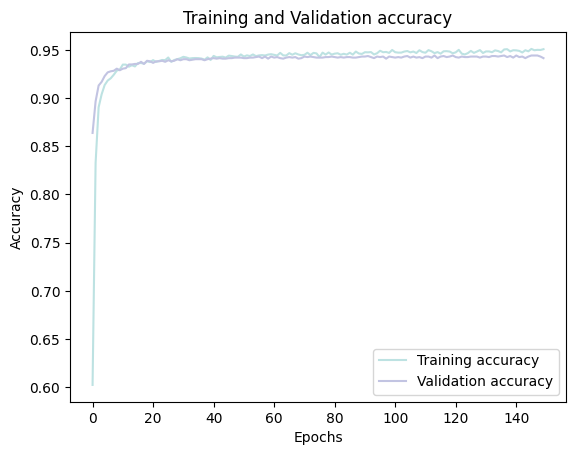

In [48]:
# Plotting training and validation accuracy over epochs
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [49]:
# Ensemble Learning in Deep Learning
# Define individual models
def create_model():
    model = Sequential()
    model.add(Input(shape=(23,)))  # Input layer
    
    # Hidden layers with Dropout and L2 Regularization
    model.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))  # Dropout with a rate of 50%
    model.add(Dense(units=64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(units=32, activation='relu', kernel_regularizer=l2(0.01)))
    
    # Output layer
    model.add(Dense(units=1, activation='sigmoid'))
    
    # Compile the model
    opt = Adam(learning_rate=0.00009)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train multiple models
models = [create_model() for _ in range(3)]
for model in models:
    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)

# Ensemble predictions (average)
predictions = [model.predict(X_test) for model in models]
final_predictions = np.mean(predictions, axis=0)
final_predictions = (final_predictions > 0.5).astype(int)


# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, final_predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

accuracy = accuracy_score(y_test, final_predictions)
precision = precision_score(y_test, final_predictions)
recall = recall_score(y_test, final_predictions)
f1 = f1_score(y_test, final_predictions)

logging.info(f"---------------------- Ensemble ANN ------------------------------------------")
logging.info(f"Mean Squared Error (MSE): {mse:.2f}")
logging.info(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
logging.info(f"Accuracy: {accuracy:.2f}")
logging.info(f"Precision: {precision:.2f}")
logging.info(f"Recall: {recall:.2f}")
logging.info(f"F1 Score: {f1:.2f}")
logging.info(f"-----------------------------------------------------------------")

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
